In [1]:
!dir

 Volume in drive D is SSD Groá
 Volume Serial Number is E892-64DB

 Directory of D:\Projects\Kaggle_8_Hacking_the_Kidney\experimental

16/04/2021  16:57    <DIR>          .
16/04/2021  16:57    <DIR>          ..
08/04/2021  21:18    <DIR>          .ipynb_checkpoints
16/04/2021  15:48           856.292 infer.ipynb
12/04/2021  21:43               513 kernel-metadata.json
07/04/2021  21:08    <DIR>          models_v01
07/04/2021  20:51    <DIR>          models_v02
16/04/2021  16:51    <DIR>          models_v0213809
12/04/2021  00:34    <DIR>          models_v05
13/04/2021  10:44    <DIR>          models_v06
13/04/2021  15:17    <DIR>          models_v07
13/04/2021  17:47    <DIR>          models_v08
13/04/2021  19:34    <DIR>          models_v09
14/04/2021  23:05    <DIR>          models_v11
15/04/2021  20:56    <DIR>          models_v12
16/04/2021  13:09    <DIR>          models_v13
08/04/2021  18:35    <DIR>          models_v69
15/04/2021  22:16             8.563 predict.ipynb
16/04/202

In [2]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4555719657767133494
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22721396736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9118439060483762703
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:09:00.0, compute capability: 8.6"
]


In [3]:
%env SM_FRAMEWORK=tf.keras
import warnings
warnings.filterwarnings("ignore")
import os
import gc
import cv2
import json
import time
import random
import numpy as np
import pandas as pd
import tifffile as tiff
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.losses import bce_jaccard_loss
print("tensorflow version:", tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    for gpu_device in gpu_devices:
        print("device available:", gpu_device)
policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)
pd.set_option("display.max_columns", None)
%matplotlib inline

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.6.0-dev20210407
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [4]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-9719cbce-a56b-1f7d-efd5-519baafcfaef)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-0b211566-f864-21f7-b80e-db06ced5fe0d)


In [49]:
VER = "v13"
PARAMS = {
    "version": VER,
    "folds": 4,
    "img_size": 256,
    "resize": 4,
    "batch_size" : 32,
    "epochs": 40,
    "patience": 20,
    "backbone": "efficientnetb7",# efficientnetbX, resnet34/50, resnext50, seresnet34, seresnext
    "loss": "bce_dice",
    "mirror": False,
    "umodel" : "unet",
    "bce_weight": 1.,
    "shift": True,
    "pseudo":"",
    "lr": 0.0002,
    "split": "kfold",
    "seed": None
}
DATA_PATH = "../input/hubmap-kidney-segmentation"


IMGS_PATH = f"{DATA_PATH}/tiles_r"
MSKS_PATH = f"{DATA_PATH}/masks_r"

MDLS_PATH = f"./models_{VER}"
if not os.path.exists(MDLS_PATH):
    os.mkdir(MDLS_PATH)
with open(f"{MDLS_PATH}/params.json", "w") as file:
    json.dump(PARAMS,file)
        

if not PARAMS["mirror"]:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    STRATEGY = tf.distribute.get_strategy()
else:
    STRATEGY = tf.distribute.MirroredStrategy()
    
start_time = time.time()

In [6]:
df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
df_masks

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...
b2dc8411c,56157731 21 56172571 45 56187411 51 56202252 5...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f,113277795 21 113315936 53 113354083 87 1133922...


In [7]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[2 * i + 1])
            img[start : start + length] = 1 + m
    return img.reshape(shape).T

def show_img_n_mask(df, img_num, resize):
    img = tiff.imread(os.path.join(f"{DATA_PATH}/train", df.index[img_num] + ".tiff"))
    if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
    mask = enc2mask(df.iloc[img_num], (img.shape[1], img.shape[0]))
    print(img.shape, mask.shape)
    img = cv2.resize(img,
                     (img.shape[1] // resize, img.shape[0] // resize),
                     interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask,
                      (mask.shape[1] // resize, mask.shape[0] // resize),
                      interpolation = cv2.INTER_NEAREST)
    plt.figure(figsize = (8, 8))
    plt.axis("off")
    plt.imshow(img)
    plt.imshow(mask, alpha = 0.4)
    plt.show()

In [8]:
class DataGenKid(Sequence):
    
    def __init__(self, imgs_path, msks_path, imgs_idxs, img_size, 
                 batch_size = 32, mode = "fit", shuffle = False,
                 resize = None):
        self.imgs_path = imgs_path
        self.msks_path = msks_path
        self.imgs_idxs = imgs_idxs
        self.img_size = img_size
        self.batch_size = batch_size
        self.mode = mode
        self.shuffle = shuffle
        self.resize = resize
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.imgs_idxs) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgs_idxs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        batch_size = min(self.batch_size, len(self.imgs_idxs) - index * self.batch_size)
        X = np.zeros((batch_size, self.img_size, self.img_size, 3), dtype = np.float32)
        imgs_batch = self.imgs_idxs[index * self.batch_size : (index + 1) * self.batch_size]
        if self.mode == "fit":
            y = np.zeros((batch_size, self.img_size, self.img_size), dtype = np.float32)
            for i, img_idx in enumerate(imgs_batch):
                X[i, ], y[i] = self.get_tile(img_idx)
            return X, y
        elif self.mode == "predict":
            for i, img_idx in enumerate(imgs_batch):
                X[i, ] = self.get_tile(img_idx)
            return X
        else:
            raise AttributeError("Fit mode parameter error")
            
    def get_tile(self, img_idx):
        img_path = f"{self.imgs_path}/{img_idx}.png"
        img = cv2.imread(img_path)
        if img is None:
            print(f"error loading image: {image_path}")
        img = img.astype(np.float32) / 255
        if self.mode == "fit":
            msk_path = f"{self.msks_path}/{img_idx}.png"
            msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
            if msk is None:
                print(f"error loading mask: {msk_path}")
            msk = msk.astype(np.float32)
            return img, msk
        else:
            return img
        

In [9]:
imgs_idxs = [x.replace(".png", "") for x in os.listdir(IMGS_PATH) if ".png" in x]
train_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MSKS_PATH,
        imgs_idxs = imgs_idxs,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit",
        shuffle = True,
        resize = None
)

val_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MSKS_PATH,
        imgs_idxs = imgs_idxs,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit",
        shuffle = False,
        resize = None
)

In [10]:
def plot_item(item_nr):
    bsize = min(8, PARAMS["batch_size"])
    Xt, yt = train_datagen.__getitem__(item_nr)
    print("test X: ", Xt.shape)
    print("test y: ", yt.shape)
    fig, axes = plt.subplots(figsize = (16, 4), nrows = 2, ncols = bsize)
    for j in range(bsize):
        axes[0, j].imshow(Xt[j])
        axes[0, j].set_title(j)
        axes[0, j].axis("off")
        axes[1, j].imshow(yt[j])
        axes[1, j].axis("off")
    plt.show()

test X:  (32, 256, 256, 3)
test y:  (32, 256, 256)


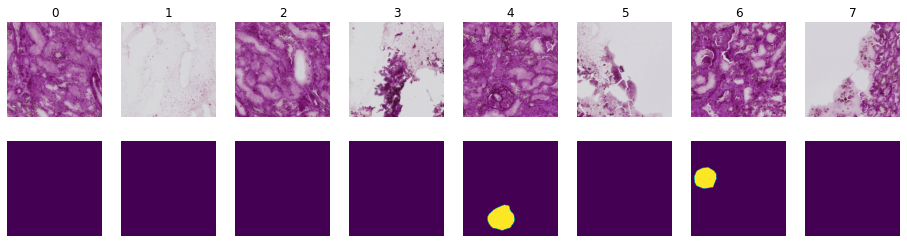

In [11]:
plot_item(223)

In [12]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return PARAMS["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - PARAMS["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice",
              umodel = "unet", classes = 1, lr = .001):
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
        
        # TODO: Implement other bce_jaccard_loss
            
        else: 
            raise AttributeError("loss mode parameter error")
        
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = "imagenet",
                         input_shape = input_shape,
                         classes = classes, activation = "sigmoid")
            
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = "imagenet",
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
        
        else:
            raise AttributeError("umodel mode parameter error")
            
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr),
                sync_period = max(6, int(PARAMS["patience"] / 4))
            ),
            loss = loss,
            metrics = [dice_coef]
        )
    return model

## Train

In [13]:
def train_model(mparams, n_fold, train_datagen, val_datagen):
    model = get_model(
        mparams["backbone"],
        input_shape = (mparams["img_size"], mparams["img_size"], 3),
        loss_type = mparams["loss"],
        umodel = mparams["umodel"],
        lr = mparams["lr"]
    )
    checkpoint_path = f"{MDLS_PATH}/model_{n_fold}.hdf5"
    earlystopper = EarlyStopping (
        monitor = "val_dice_coef",
        patience = mparams["patience"],
        verbose = 0,
        restore_best_weights = True,
        mode = "max"
    )
    lrreducer = ReduceLROnPlateau(
        monitor = "val_dice_coef",
        factor = .1,
        patience = int(mparams["patience"] / 2),
        verbose = 0,
        min_lr = 1e-7,
        mode = "max"
    )
    checkpointer = ModelCheckpoint(
        checkpoint_path,
        monitor = "val_dice_coef",
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = "max"
    )
    callbacks = [earlystopper, checkpointer]
    callbacks.append(lrreducer)
    print("lr reduce on plateau")
    history = model.fit(
        train_datagen,
        validation_data = val_datagen,
        callbacks = callbacks,
        epochs = mparams["epochs"],
        verbose = 1
    )
    history_file = f"{MDLS_PATH}/history_{n_fold}.json"
    dict_to_save = {}
    for k, v in history.history.items():
        dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
    with open(history_file, "w") as file:
        json.dump(dict_to_save, file)
    model.load_weights(checkpoint_path)
    return model, history  

In [14]:
for iname in list(set([x[:9] for x in imgs_idxs])):
    print("img name:", iname,
          "| imgs number:", len([x for x in imgs_idxs if x[:9] == iname]))
if PARAMS["split"] == "kfold":
    kfold = KFold(n_splits = PARAMS["folds"],
                  random_state = PARAMS["seed"],
                  shuffle = True).split(imgs_idxs)
else:
    raise AttributeError("split mode parameter error")

img name: b9a3865fc | imgs number: 1629
img name: aaa6a05cc | imgs number: 285
img name: 1e2425f28 | imgs number: 1191
img name: 095bf7a1f | imgs number: 1399
img name: afa5e8098 | imgs number: 2343
img name: b2dc8411c | imgs number: 445
img name: 8242609fa | imgs number: 1597
img name: cb2d976f4 | imgs number: 1913
img name: 2f6ecfcdf | imgs number: 666
img name: 54f2eec69 | imgs number: 608
img name: e79de561c | imgs number: 668
img name: 0486052bb | imgs number: 754
img name: c68fe75ea | imgs number: 2397
img name: 4ef6695ce | imgs number: 2504
img name: 26dc41664 | imgs number: 1632


In [ ]:
epoch_by_folds = []
loss_by_folds = []
dice_coef_by_folds = []

for n, (tr, te) in enumerate(kfold):
    print("=" * 10, f"FOLD {n}", "=" * 10)
    X_tr = [imgs_idxs[i] for i in tr]; X_val = [imgs_idxs[i] for i in te]
    print("train:", len(X_tr), "| test:", len(X_val))
    print("groups train:", set([x[:9] for x in X_tr]),
          "\ngroups test:", set([x[:9] for x in X_val]))
    train_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MSKS_PATH,
        imgs_idxs = X_tr,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit",
        shuffle = True,
        resize = None
    )
    
    val_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MSKS_PATH,
        imgs_idxs = X_val,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit",
        shuffle = False,
        resize = None
    )
    model, history = train_model(PARAMS, n, train_datagen, val_datagen)
    
    plt.plot(history.history["loss"], label = "loss")
    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.legend()
    plt.show()
    plt.plot(history.history["dice_coef"], label = "dice_coef")
    plt.plot(history.history["val_dice_coef"], label = "val_dice_coef")
    plt.legend()
    plt.show()
    best_epoch = np.argmax(history.history["val_dice_coef"])
    best_loss = history.history["val_loss"][best_epoch]
    best_dice_coef = history.history["val_dice_coef"][best_epoch]
    print("best epoch:", best_epoch,
         "| best loss:", best_loss,
         "| best dice coef:", best_dice_coef)
    epoch_by_folds.append(best_epoch)
    loss_by_folds.append(best_loss)
    dice_coef_by_folds.append(best_dice_coef)
    del train_datagen, val_datagen, model; gc.collect()

elapsed_time = time.time() - start_time
print(f"time elapsed: {elapsed_time // 60:.0f} min {elapsed_time % 60:.0f} sec")

In [ ]:
result = PARAMS.copy()
result["bavg_epoch"] = np.mean(epoch_by_folds)
result["bavg_loss"] = np.mean(loss_by_folds)
result["bavg_dice_coef"] = np.mean(dice_coef_by_folds)
result["dice_by_folds"] = " ".join([f"{x:.4f}" for x in dice_coef_by_folds])
with open(f"{MDLS_PATH}/params.json", "w") as file:
    json.dump(result, file)
if not os.path.exists("results.csv"):
    df_save = pd.DataFrame(result, index = [0])
    df_save.to_csv("results.csv", sep = "\t")
else:
    df_old = pd.read_csv("results.csv", sep = "\t", index_col = 0)
    df_save = pd.DataFrame(result, index = [df_old.index.max() + 1])
    df_save = df_old.append(df_save, ignore_index = True)
    df_save.to_csv("results.csv", sep = "\t")

In [15]:
pd.read_csv("results.csv", sep = "\t", index_col=0).iloc[:,4:]

,version,folds,img_size,resize,batch_size,epochs,patience,backbone,loss,mirror,umodel,bce_weight,shift,pseudo,lr,best_epoch,best_loss,best_dice_coef,split,seed,bavg_epoch,bavg_loss,bavg_dice_coef,dice_by_folds
0,v05,6,256,4,20,2,20,efficientnetb2,bce_dice,False,unet,1.0,True,NaN,0.0002,1.0,0.022014,0.630520,NaN,NaN,NaN,NaN,NaN,NaN
1,v06,6,256,4,20,30,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,25.0,0.004156,0.894248,NaN,NaN,NaN,NaN,NaN,NaN
2,v07,1,256,4,20,30,20,efficientnetb6,bce_dice,False,unet,1.0,True,NaN,0.0002,8.0,0.774364,0.059264,NaN,NaN,NaN,NaN,NaN,NaN
3,v11,2,256,4,36,2,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0002,0.0,0.042853,0.042853,kfold,NaN,NaN,NaN,NaN,NaN
4,v11,2,256,4,32,2,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0002,1.0,0.088933,0.088933,kfold,NaN,NaN,NaN,NaN,NaN
5,v12,6,256,4,32,50,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,NaN,NaN,NaN,NaN
6,v12,2,256,4,32,2,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,0.5,0.368191,0.140009,0.0926 0.1874
7,v13,4,256,4,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,15.5,0.236562,0.454637,0.6554 0.4974 0.5797 0.0861


## Predict

In [50]:
larger = 4
test_models = []
for n_fold in list(range(PARAMS["folds"])):
    
    checkpoint_path = f"{MDLS_PATH}/model_{n_fold}.hdf5"
    print(checkpoint_path)
    model_lrg = get_model (
        PARAMS["backbone"],
        input_shape = (PARAMS["img_size"] * larger, PARAMS["img_size"] * larger, 3),
        loss_type = PARAMS["loss"],
        umodel = PARAMS["umodel"]
    )
    model_lrg.load_weights(checkpoint_path) # or .set_weights(model.get_weights()) from smaller model
    test_models.append(model_lrg)

./models_v13/model_0.hdf5
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

./models_v13/model_1.hdf5
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

./models_v13/model_2.hdf5
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

./models_v13/model_3.hdf5
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



(31278, 25794, 3) (31278, 25794)
(1024, 1024, 3)


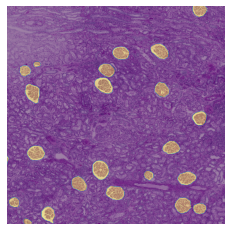

In [51]:
img_num = 0
resize = PARAMS["resize"]
shft = 0.6
wnd = PARAMS["img_size"] * larger
img = tiff.imread(os.path.join(f"{DATA_PATH}/train", df_masks.index[img_num] + ".tiff"))
if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
mask = enc2mask(df_masks.iloc[img_num], (img.shape[1], img.shape[0]))
print(img.shape, mask.shape)
img = cv2.resize(img,
                 (img.shape[1] // resize, img.shape[0] // resize),
                 interpolation = cv2.INTER_AREA)
mask = cv2.resize(mask,
                  (mask.shape[1] // resize, mask.shape[0] // resize),
                  interpolation = cv2.INTER_NEAREST)
img = img[int(img.shape[0] * shft) : int(img.shape[0] * shft) + wnd,
          int(img.shape[1] * shft) : int(img.shape[1] * shft) + wnd,
          :]
mask = mask[int(mask.shape[0] * shft) : int(mask.shape[0] * shft) + wnd,
            int(mask.shape[1] * shft) : int(mask.shape[1] * shft) + wnd]
plt.figure(figsize = (4, 4))
plt.axis("off")
plt.imshow(img)
print(img.shape)
plt.imshow(mask, alpha = 0.4)
plt.show()

In [52]:
def dice_np(pred, true, k = 1):
    intersection = np.sum(pred[true == k]) * 2
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def get_dice(mask, mask_lrg, th):
    mask_pred = np.squeeze(mask_lrg > th).astype(int)
    return dice_np(mask, mask_pred)

def get_best_th_dice(mask, mask_lrg, n=100, plot = False):
    thresholds = np.linspace(0, 1, n)
    dices = [get_dice(mask, mask_lrg, th) for th in thresholds]
    n_max = np.argmax(dices)
    if plot:
        plt.plot(thresholds, dices)
        plt.title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
        plt.show()
    return thresholds[n_max], dices[n_max]

In [53]:
masks_lrg = []
for j in range(len(test_models)):
    mask_lrg = test_models[j].predict(img[np.newaxis, ] / 255).astype(np.float32)
    masks_lrg.append(mask_lrg)

(0.3434343434343435, 0.8763380207786756)
(0.15151515151515152, 0.9114308245912829)
(0.4444444444444445, 0.9387649779342195)
(0.98989898989899, 0.5622003412793621)


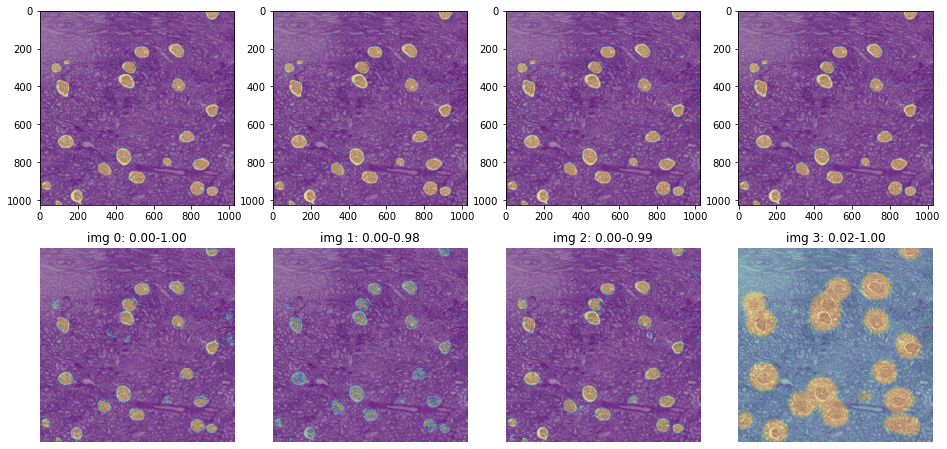

In [56]:
fig, axes = plt.subplots(figsize = (16, 8), nrows = 2, ncols = len(test_models))
if len(test_models) == 1:
    for j in range(len(test_models)):
        mask_lrg = masks_lrg[j]
        axes[0].imshow(img)
        axes[0].imshow(mask, alpha = 0.4)
        axes[1].imshow(img)
        axes[1].imshow(np.squeeze(mask_lrg), alpha = 0.4)
        axes[1].set_title(f"img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}")
        axes[1].axis("off")
        print(get_best_th_dice(mask, mask_lrg))
    plt.show()
else:
    for j in range(len(test_models)):
        mask_lrg = masks_lrg[j]
        axes[0,j].imshow(img)
        axes[0,j].imshow(mask, alpha = 0.4)
        axes[1,j].imshow(img)
        axes[1,j].imshow(np.squeeze(mask_lrg), alpha = 0.4)
        axes[1,j].set_title(f"img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}")
        axes[1,j].axis("off")
        print(get_best_th_dice(mask, mask_lrg))
    plt.show()
    

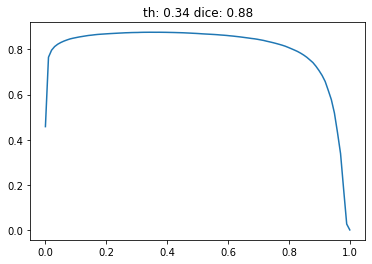

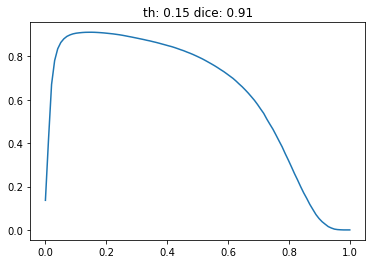

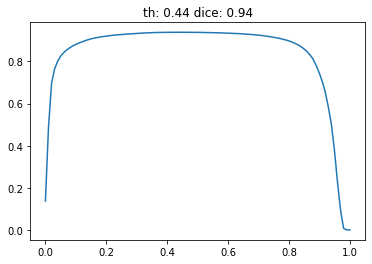

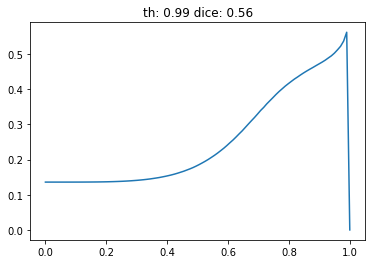

In [57]:
for mask_lrg in masks_lrg:
    get_best_th_dice(mask, mask_lrg, n = 100, plot = True)

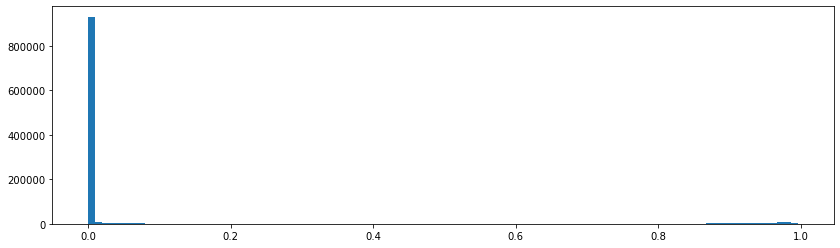

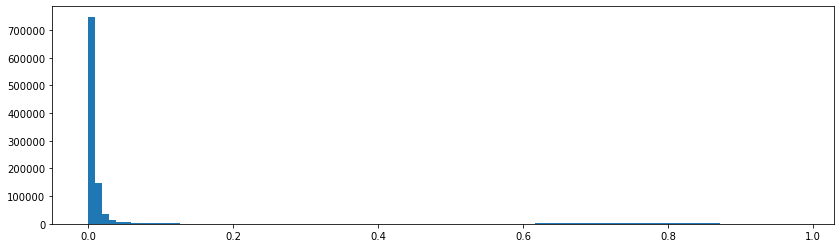

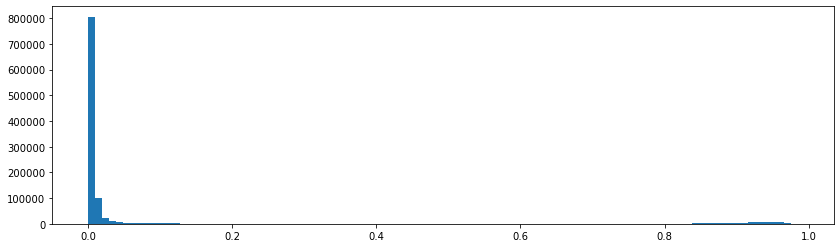

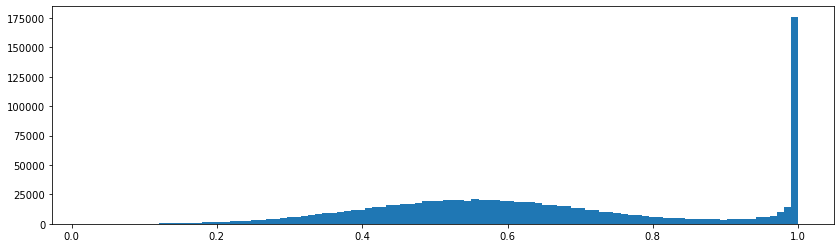

In [58]:
for mask_lrg in masks_lrg:
    plt.figure(figsize = (14, 4))
    plt.hist(mask_lrg.flatten(), bins = 100)
    plt.show()

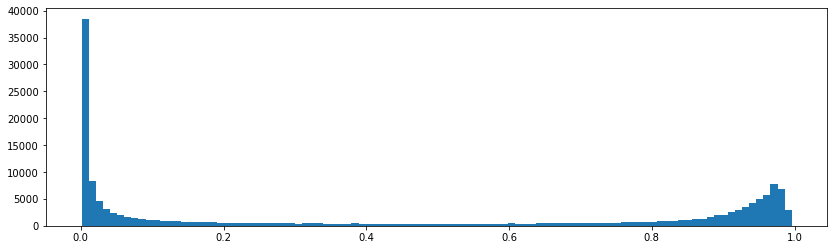

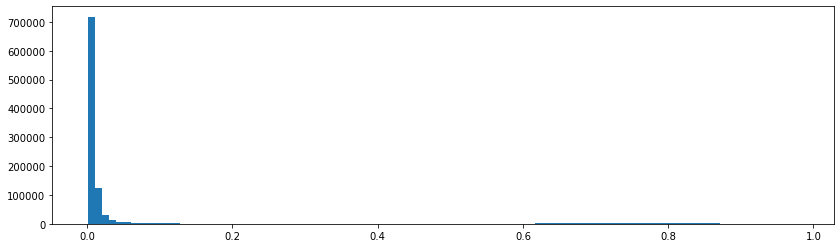

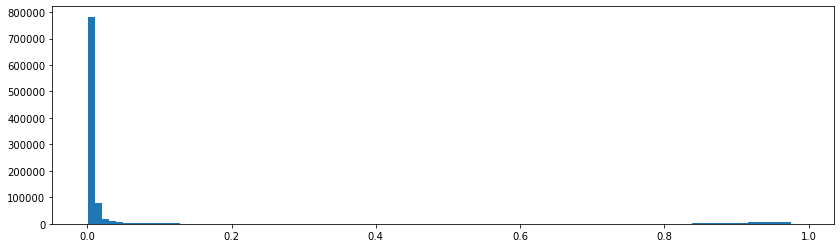

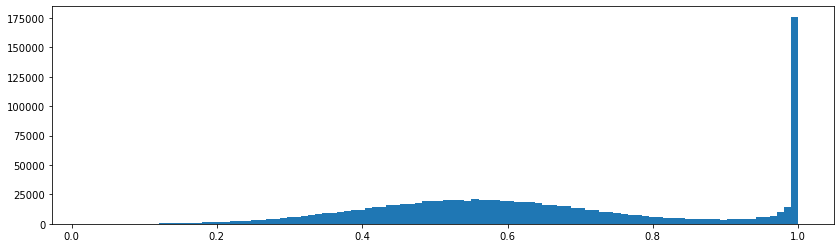

In [59]:
for mask_lrg in masks_lrg:
    plt.figure(figsize = (14, 4))
    plt.hist(np.where(mask_lrg < 10e-4, np.nan, mask_lrg).flatten(), bins = 100)
    plt.show()